How do the different ways of calculating the rotational velocity compare?

In [15]:
import numpy as np

from astropy.table import Table, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
import astropy.constants as const

import matplotlib.pyplot as plt

In [16]:
c = const.c.to('km/s')

In [3]:
# We're going to use real data
tiron_all = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_iron_healpix.fits')
tiron = unique(tiron_all)
tiron[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
-411444222,156.21815002209,7.15848284808457,27449,main,0.102481637685212,9.09103522467823e-05,2053,0.0467898591887206,iron/healpix/main/backup/274/27449/redrock-main-backup-27449.fits,TFT,4614,156.21810707253144,7.1582430702316175
-256075243,267.712765090224,29.4851124724098,32659,main,0.0249376137955555,2.44308294845057e-05,2560,1544.51990368162,iron/healpix/main/bright/326/32659/redrock-main-bright-32659.fits,SGA,447725,267.7127798938763,29.484990855307803
-255474428,318.116492659747,-5.28401899381209,49107,main,0.0489536329997778,7.85721765764138e-05,512,67.7162851418252,iron/healpix/main/bright/491/49107/redrock-main-bright-49107.fits,TFT,342501,318.1167585749797,-5.283990383719008
-239472210,323.502907257596,2.59623615801086,19168,main,0.0570545794337428,2.47376442711859e-05,2560,36.3351525710896,iron/healpix/main/bright/191/19168/redrock-main-bright-19168.fits,TFT,1245160,323.5028651783498,2.5963714595607508
-236269010,159.441551301486,11.8164401561333,27589,main,0.0536937948152313,2.00541500335771e-06,2560,17253.9541264772,iron/healpix/main/bright/275/27589/redrock-main-bright-27589.fits,SGA,112426,159.44167440686755,11.816368587372878


In [5]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the fuji data into center and off-center observations

In [10]:
tiron['SKY_FIBER_DIST'] = 0.
tiron['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tiron['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx], 
                             dec=tiron['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [11]:
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

# Clean the fuji center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [12]:
good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]

# If a galaxy has at least one observation at its center, set the redshift of that galaxy

In [14]:
iron_axis['Z_CENTER'] = np.nan
iron_axis['ZERR_CENTER'] = np.nan

weights = 1./(good_centers['ZERR']**2)

n = 0

delta_z = np.array([])

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find all the off-center observations on this galaxy
    axis_idx = iron_axis['SGA_ID'] == sga_id
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    iron_axis['Z_CENTER'][axis_idx] = np.average(good_centers['Z'][obs_idx], 
                                                weights=weights[obs_idx])
    iron_axis['ZERR_CENTER'][axis_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

# Calculate rotational velocities

There are a few ways to calculate the rotational velocities for the galaxies.  Let's take a look at how they compare.

In [17]:
def z_diff(z_center, z_axis):
    return c*(z_axis - z_center)


def z_pv(z_center, z_axis):
    return c*( (1 + z_axis)/(1 + z_center) - 1)

In [18]:
iron_axis['V_ROT_DIFF'] = z_diff(iron_axis['Z_CENTER'], iron_axis['Z'])

iron_axis['V_ROT_PV'] = z_pv(iron_axis['Z_CENTER'], iron_axis['Z'])

In [20]:
# Only look at observations at 0.4R26 with 10 < V < 1000 km/s
r0p4 = (iron_axis['SKY_FIBER_DIST_R26'] > 0.35) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.45)
Vgood = (np.abs(iron_axis['V_ROT_DIFF']) < 1000) & (np.abs(iron_axis['V_ROT_DIFF']) >= 10)
good_axis = iron_axis[r0p4 & Vgood]

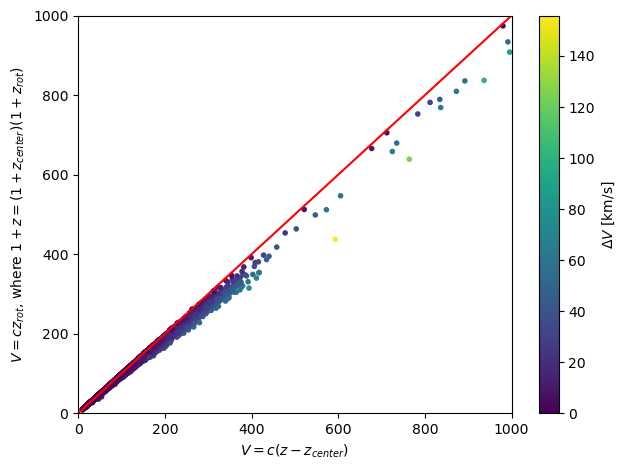

In [32]:
plt.figure(tight_layout=True)

plt.scatter(np.abs(good_axis['V_ROT_DIFF']), 
            np.abs(good_axis['V_ROT_PV']), 
            c=np.abs(good_axis['V_ROT_DIFF']) - np.abs(good_axis['V_ROT_PV']), 
            marker='.', 
            # alpha=0.1
           )
plt.plot([0, 1000], [0, 1000], 'r')

plt.xlim([0, 1000])
plt.ylim([0, 1000])

plt.colorbar(label='$\Delta V$ [km/s]')

plt.xlabel('$V = c(z - z_{center})$')
plt.ylabel('$V = cz_{rot}$, where $1 + z = (1 + z_{center})(1 + z_{rot})$');

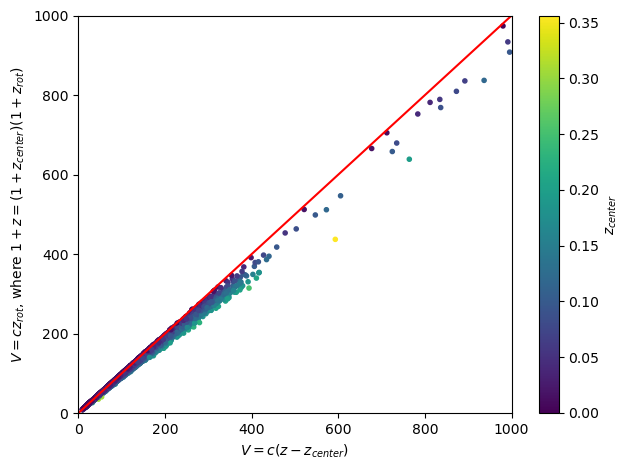

In [33]:
plt.figure(tight_layout=True)

plt.scatter(np.abs(good_axis['V_ROT_DIFF']), 
            np.abs(good_axis['V_ROT_PV']), 
            c=good_axis['Z_CENTER'], 
            marker='.', 
            # alpha=0.1
           )
plt.plot([0, 1000], [0, 1000], 'r')

plt.xlim([0, 1000])
plt.ylim([0, 1000])

plt.colorbar(label='$z_{center}$')

plt.xlabel('$V = c(z - z_{center})$')
plt.ylabel('$V = cz_{rot}$, where $1 + z = (1 + z_{center})(1 + z_{rot})$');